In [2]:
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = "/content/drive/My Drive/VoiceDataSet/Emotions"


In [5]:
emotion_categories= os.listdir(dataset_path)
print("Emotion categories:",emotion_categories)

Emotion categories: ['Happy', 'Neutral', 'Angry', 'Disgusted', 'Fearful', 'Sad', 'Suprised']


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def augment_audio(audio, sr):
    """
    Apply augmentations:
      - Original audio
      - Time-stretched (slowed down to 90% of original speed)
      - Time-shifted (shifted by 1/10th of a second)
      - Noisy (added small random noise)
    Returns a list of augmented audio signals.
    """
    # Original audio (no change)
    audio_original = audio

    # Time-stretching: slow down to 90% speed
    audio_stretched = librosa.effects.time_stretch(audio, rate=0.9)

    # Time-shifting: shift the audio forward by 1/10th of a second
    audio_shifted = np.roll(audio, sr // 10)

    # Adding noise: small Gaussian noise added to the audio signal
    noise = 0.005 * np.random.randn(len(audio))
    audio_noisy = audio + noise


    return [audio_original, audio_stretched, audio_shifted, audio_noisy]

In [ ]:
def extract_features(audio, sr, n_mfcc=40, max_pad_len=100):
    """
    Extracts MFCC features from the audio, transposes them to shape (time_steps, n_mfcc),
    and pads or truncates the sequence to a fixed length (max_pad_len).
    """
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = mfcc.T  # Transpose to shape (time_steps, n_mfcc)

    # Pad or truncate to a fixed number of time steps (max_pad_len)
    if mfcc.shape[0] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[0]
        mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:max_pad_len, :]

    return mfcc  # Final shape: (max_pad_len, n_mfcc)

In [ ]:

# Initialize lists to hold features and labels
features_list = []
labels_list = []

# Loop through each emotion category and process files
for category in emotion_categories:
    category_path = os.path.join(dataset_path, category)
    audio_files = [f for f in os.listdir(category_path) if f.endswith('.wav')]

    print(f"Processing {len(audio_files)} files from '{category}'...")

    for file in audio_files:
        file_path = os.path.join(category_path, file)

        try:
            # Load the audio file with a fixed sampling rate (16,000 Hz)
            audio, sr = librosa.load(file_path, sr=16000)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue

        # Generate augmented versions of the audio
        augmented_audios = augment_audio(audio, sr)

        # Extract features from each augmented audio version
        for aug_audio in augmented_audios:
            mfcc_features = extract_features(aug_audio, sr, n_mfcc=40, max_pad_len=100)
            features_list.append(mfcc_features)
            labels_list.append(category)


Processing 2173 files from 'Happy'...
Processing 1799 files from 'Neutral'...
Processing 2167 files from 'Angry'...
Processing 1863 files from 'Disgusted'...
Processing 2047 files from 'Fearful'...
Processing 2167 files from 'Sad'...
Processing 592 files from 'Suprised'...


In [ ]:
import librosa
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
X= np.array(features_list)  # Shape: (num_samples, max_pad_len, n_mfcc)
y = np.array(labels_list)

print("Feature extraction complete!")
print("X shape before normalization:", X.shape)
print("Number of labels:", len(y))
num_samples, time_steps, n_mfcc = X.shape
X_reshaped = X.reshape(num_samples, time_steps * n_mfcc)

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_reshaped)

# Reshape back to original 3D shape for model input
X_normalized = X_normalized.reshape(num_samples, time_steps, n_mfcc)

print("X shape after normalization:", X_normalized.shape)

# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Encoded labels (unique):", np.unique(y_encoded))



Feature extraction complete!
X shape before normalization: (51232, 100, 40)
Number of labels: 51232
X shape after normalization: (51232, 100, 40)
Encoded labels (unique): [0 1 2 3 4 5 6]


In [ ]:
from sklearn.model_selection import train_test_split

# Assume X_normalized and y_encoded are your features and labels after preprocessing

# First, split the dataset into 70% training and 30% temporary (for CV + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Then, split the temporary set equally into 15% CV and 15% Test
X_cv, X_test, y_cv, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Cross-validation set shape:", X_cv.shape, y_cv.shape)
print("Test set shape:", X_test.shape, y_test.shape)


# Define the directory where you want to save the test data
save_dir = "/content/drive/My Drive/Preprocessed_Augmented_Data"
os.makedirs(save_dir, exist_ok=True)

# Save the test features and labels as .npy files
np.save(os.path.join(save_dir, "X_cv.npy"), X_cv)
np.save(os.path.join(save_dir, "y_cv.npy"), y_cv)

print("Test data saved to:", save_dir)


Training set shape: (35862, 100, 40) (35862,)
Cross-validation set shape: (7685, 100, 40) (7685,)
Test set shape: (7685, 100, 40) (7685,)
Test data saved to: /content/drive/My Drive/Preprocessed_Augmented_Data


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Bidirectional, LSTM, Reshape
from tensorflow.keras.models import Model

def build_bilstm_cnn(input_shape, num_classes=7):
    input_seq = Input(shape=input_shape, name="input_seq")

    ### Branch 1: BiLSTM for sequential learning
    # Increase LSTM units to capture more temporal dynamics
    x1 = Bidirectional(LSTM(128, return_sequences=False))(input_seq)  # Output shape: (256,) since 128 units per direction
    x1 = Dense(64, activation='relu')(x1)

    ### Branch 2: 2D CNN for spatial feature extraction
    # Reshape input to add channel dimension: (time_steps, features, 1)
    x2 = Reshape((input_shape[0], input_shape[1], 1))(input_seq)
    # Use more filters for better feature extraction
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    x2 = GlobalAveragePooling2D()(x2)
    x2 = Dense(64, activation='relu')(x2)

    ### Fusion: Concatenate both branches
    merged = Concatenate()([x1, x2])
    merged = Dense(64, activation='relu')(merged)
    merged = Dropout(0.5)(merged)
    output = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=input_seq, outputs=output)
    # Use a slightly lower learning rate for fine-tuning
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define input shape (e.g., 100 time steps, 40 features) and number of classes (7 emotions)
input_shape = (100, 40)
num_classes = 7
model = build_bilstm_cnn(input_shape, num_classes)
model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

# Create directory to save the best model (using the native Keras format)
save_dir = "/content/drive/My Drive/Emotion_Model"
os.makedirs(save_dir, exist_ok=True)

# Define ModelCheckpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(
    os.path.join(save_dir, 'best_model_BiLSTM_2D_CNNN.keras'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Compile the model with Adam optimizer and a learning rate of 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model (assuming X_train, y_train, X_cv, y_cv are defined)
history = model.fit(
    X_train, y_train,
    epochs=50,       # High epoch count; early stopping will stop if no improvement
    batch_size=32,
    validation_data=(X_cv, y_cv),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Optionally evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



In [ ]:
# Assume 'history' is from model.fit(), and your test data is X_test and y_test

# Final training and validation metrics from the history object
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print("Final Training Loss: {:.4f}".format(final_train_loss))
print("Final Training Accuracy: {:.4f}".format(final_train_accuracy))
print("Final Validation Loss: {:.4f}".format(final_val_loss))
print("Final Validation Accuracy: {:.4f}".format(final_val_accuracy))

# Evaluate on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_accuracy))


<ipython-input-5-387328a42d9c>:6: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load("/content/WhatsApp Audio 2025-03-29 at 10.39.38 AM.aac", sr=16000)


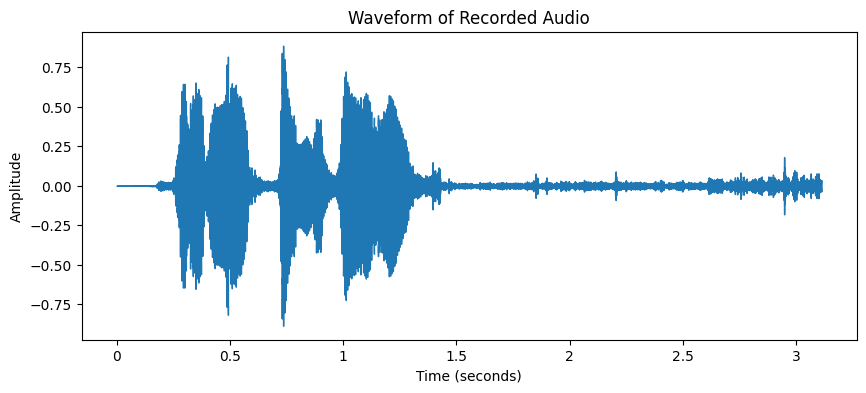

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load recorded audio
audio, sr = librosa.load("/content/WhatsApp Audio 2025-03-29 at 10.39.38 AM.aac", sr=16000)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform of Recorded Audio")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Concatenate, Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, GlobalAveragePooling1D, Bidirectional,
    LSTM, LayerNormalization, MultiHeadAttention, Reshape
)

# Define all custom layers used in your model
custom_objects = {
    "Input": Input,
    "Dense": Dense,
    "Dropout": Dropout,
    "Concatenate": Concatenate,
    "Conv2D": Conv2D,
    "MaxPooling2D": MaxPooling2D,
    "GlobalAveragePooling2D": GlobalAveragePooling2D,
    "GlobalAveragePooling1D": GlobalAveragePooling1D,
    "Bidirectional": Bidirectional,
    "LSTM": LSTM,
    "LayerNormalization": LayerNormalization,
    "MultiHeadAttention": MultiHeadAttention,
    "Reshape": Reshape
}

def extract_features(audio, sr=16000, n_mfcc=40, max_pad_len=100):
    """Extract MFCCs and pad/truncate to fixed length."""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = mfcc.T  # Shape: (time_steps, n_mfcc)
    if mfcc.shape[0] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:max_pad_len, :]
    return mfcc

def predict_emotion(audio_file):
    # Load audio
    audio, _ = librosa.load(audio_file, sr=16000)

    # Extract features
    features = extract_features(audio)  # Shape: (100, 40)
    input_features = np.expand_dims(features, axis=0)  # Add batch dimension

    # Load model
    model = tf.keras.models.load_model(
        "/content/drive/MyDrive/Emotion_Model/best_model_BiLSTM_2D_CNN.keras"
    )

    # Predict
    prediction = model.predict(input_features)
    predicted_class = np.argmax(prediction)


    # Map to emotion labels (update these to match your training labels!)
    emotion_labels = ["Angry", "Happy", "Neutral", "Sad", "Disgusted", "Fearful", "Surprised"]
    return emotion_labels[predicted_class]

# Example usage
audio_path1 = "/content/WhatsApp Audio 2025-03-29 at 10.39.38 AM.aac"
print("Predicted Emotion 1:", predict_emotion(audio_path1))


<ipython-input-6-3d0d2cdb31cd>:40: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(audio_file, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicted Emotion 1: Sad


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, LSTM, Bidirectional, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import os

# Load preprocessed data
path = "/content/drive/MyDrive/Preprocessed_Augmented_Data__/"
X_train = np.load(os.path.join(path, "X_train.npy"))
y_train = np.load(os.path.join(path, "y_train.npy"))
X_test = np.load(os.path.join(path, "X_test.npy"))
y_test = np.load(os.path.join(path, "y_test.npy"))
X_cv = np.load(os.path.join(path, "X_cv.npy"))
y_cv = np.load(os.path.join(path, "y_cv.npy"))

# Get number of classes and ensure labels are integers (not one-hot)
num_classes = len(np.unique(y_train))


241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


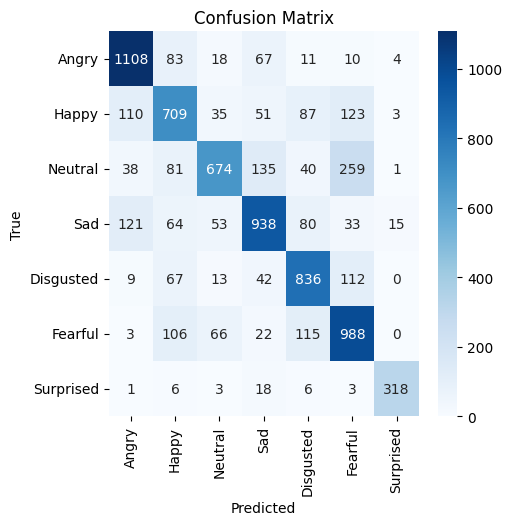

              precision    recall  f1-score   support

       Angry       0.80      0.85      0.82      1301
       Happy       0.64      0.63      0.63      1118
     Neutral       0.78      0.55      0.64      1228
         Sad       0.74      0.72      0.73      1304
   Disgusted       0.71      0.77      0.74      1079
     Fearful       0.65      0.76      0.70      1300
   Surprised       0.93      0.90      0.91       355

    accuracy                           0.72      7685
   macro avg       0.75      0.74      0.74      7685
weighted avg       0.73      0.72      0.72      7685



In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Load saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Emotion_Model/best_model_BiLSTM_2D_CNN.keras')

# Generate predictions directly from test data
y_pred = model.predict(X_test)  # Use your existing X_test data
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting (replace le_classes with your actual class labels)
class_labels = ["Angry", "Happy", "Neutral", "Sad", "Disgusted", "Fearful", "Surprised"]

plt.figure(figsize=(5,5))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=class_labels))

In [9]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7269 - loss: 0.7307
Test Accuracy: 72.49%
